# Evaluation TAL: Traitement Automatique du Langage

__

Dans ce travail nous avons pour but de démontrer notre capacité à créer une chaine de traitement des données textuelles sur l'analyse d'opinion et la classification de locuteur. Pour ce faire nous aurons deux jeux de données :
- Revues de film
- Chirac/Mitterand

> ## Classification de documents : prise en main des outils
Le but de ce TP est de classer des documents textuels... Dans un premier temps, nous allons vérifier le bon fonctionnement des outils sur des données jouets puis appliquer les concepts sur des données réelles.

> ###      Conception de la chaine de traitement
Pour rappel, une chaine de traitement de documents classique est composée des étapes suivantes:
> 1. Lecture des données et importation
    - Dans le cadre de nos TP, nous faisons l'hypothèse que le corpus tient en mémoire... Si ce n'est pas le cas, il faut alors ajouter des structures de données avec des buffers (*data-reader*), bien plus complexes à mettre en place.
    - Le plus grand piège concerne l'encodage des données. Dans le TP... Pas (ou peu) de problème. Dans la vraie vie: il faut faire attention à toujours maitriser les formats d'entrée et de sortie.
> 2. Traitement des données brutes paramétrique. Chaque traitement doit être activable ou desactivable + paramétrable si besoin.
    - Enlever les informations *inutiles* : chiffre, ponctuations, majuscules, etc... (**L'utilité dépend de l'application!**)
    - Segmenter en mots (=*Tokenization*)
    - Elimination des stop-words
    - Stemming/lemmatisation (racinisation)
    - Byte-pair encoding pour trouver les mots composés (e.g. Sorbonne Université, Ville de Paris, Premier Ministre, etc...)
> 3. Traitement des données numériques
    - Normalisation *term-frequency* / binarisation
    - Normalisation *inverse document frequency*
    - Elimination des mots rares, des mots trop fréquents
    - Construction de critère de séparabilité pour éliminer des mots etc...
> 4. Apprentissage d'un classifieur
    - Choix du type de classifieur
    - Réglage des paramètres du classifieur (régularisation, etc...)

> ### Exploitation de la chaine de traitement
On appelle cette étape la réalisation d'une campagne d'expériences: c'est le point clé que nous voulons traviller en TAL cette année.
> 1. Il est impossible de tester toutes les combinaisons par rapport aux propositions ci-dessus... Il faut donc en éliminer un certain nombre.
    - En discutant avec les experts métiers
    - En faisant des tests préliminaires
> 2. Après ce premier filtrage, il faut:
    - Choisir une évaluation fiable et pas trop lente (validation croisée, leave-one-out, split apprentissage/test simple)
    - Lancer des expériences en grand
        - = *grid-search*
        - parallèliser sur plusieurs machines
        - savoir lancer sur un serveur et se déconnecter
> 3. Collecter et analyser les résultats


>### Inférence
L'inférence est ensuite très classique: la chaine de traitement optimale est apte à traiter de nouveaux documents

In [191]:
import numpy as np
import matplotlib.pyplot as plt #%matplotlib inline
import random as rnd

import codecs
import re
import os.path

## 1. Analyse d'opinion sur des revues de film

**Analyses obligatoires**
- Comparer les performances avec différents pré-traitements
    - e.g Taille de vocabulaire, unigram/bigram, Stemming, ...
- Appliquer les traitements optimaux sur les données de test et sauver les résultats dans un fichier txt

**Compléments optionnels**
- Analyser les performances avec Word2Vec, en utilisant des stratégies d'agrégation naïves


### a) Load Data 

#### i) Load Movies and labs

In [192]:
def load_movies(path2data): # 1 classe par répertoire
    alltxts = [] # init vide
    labs = []
    cpt = 0
    for cl in os.listdir(path2data): # parcours des fichiers d'un répertoire
        for f in os.listdir(path2data+cl):
            txt = open(path2data+cl+'/'+f).read()
            alltxts.append(txt)
            labs.append(cpt)
        cpt+=1 # chg répertoire = cht classe
        
    return alltxts,labs

In [193]:
path = "ressources/movies/movies1000/"

alltxts,alllabs = load_movies(path)

In [194]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])

2000 2000
plot : two teen couples go to a church party , drink and then drive . 
they get into an accident . 
one of the guys dies , but his girlfriend continues to see him in her life , and has nightmares . 
what's the deal ? 
watch the movie and " sorta " find out . . . 
critique : a mind-fuck movie for the teen generation that touches on a very cool idea , but presents it in a very bad package . 
which is what makes this review an even harder one to write , since i generally applaud films which attempt to break the mold , mess with your head and such ( lost highway & memento ) , but there are good and bad ways of making all types of films , and these folks just didn't snag this one correctly . 
they seem to have taken this pretty neat concept , but executed it terribly . 
so what are the problems with the movie ? 
well , its main problem is that it's simply too jumbled . 
it starts off " normal " but then downshifts into this " fantasy " world in which you , as an audience member , 

#### ii) Split data into train and test

In [195]:
size_test = round(0.80*len(alltxts))
index_train_txts = rnd.sample(range(len(alltxts)), size_test)

train_txts = [alltxts[txt] for txt in index_train_txts]
train_labs = [alllabs[txt] for txt in index_train_txts]

test_texts = [alltxts[txt] for txt in range(len(alltxts)) if txt not in index_train_txts]
test_labs = [alllabs[txt] for txt in range(len(alllabs)) if txt not in index_train_txts]

#print(len(alltxts), len(test_texts), len(train_txts))

#### ii) Data balance

> #### Equilibrage des données
Un problème reconnu comme dur dans la communauté est celui de l'équilibrage des classes (*balance* en anglais). Que faire si les données sont à 80, 90 ou 99% dans une des classes?
Le problème est dur mais fréquent; les solutions sont multiples mais on peut isoler 3 grandes familles de solution.
> 1. Ré-équilibrer le jeu de données: supprimer des données dans la classe majoritaire et/ou sur-échantilloner la classe minoritaire.
   $\Rightarrow$ A vous de jouer pour cette technique
> 2. Changer la formulation de la fonction de coût pour pénaliser plus les erreurs dans la classe minoritaire:
soit une fonction $\Delta$ mesurant les écarts entre $f(x_i)$ et $y_i$ 
$$C = \sum_i  \alpha_i \Delta(f(x_i),y_i), \qquad \alpha_i = \left\{
\begin{array}{ll}
1 & \text{si } y_i \in \text{classe majoritaire}\\
B>1 & \text{si } y_i \in \text{classe minoritaire}\\
\end{array} \right.$$
   $\Rightarrow$ Les SVM et d'autres approches sklearn possèdent des arguments pour régler $B$ ou $1/B$... Ces arguments sont utiles mais pas toujours suffisant.
> 3. Courbe ROC et modification du biais. Une fois la fonction $\hat y = f(x)$ apprise, il est possible de la *bidouiller* a posteriori: si toutes les prédictions $\hat y$ sont dans une classe, on va introduire $b$ dans $\hat y = f(x) + b$ et le faire varier jusqu'à ce qu'un des points change de classe. On peut ensuite aller de plus en plus loin.
Le calcul de l'ensemble des scores associés à cette approche mène directement à la courbe ROC.
**Note:** certains classifieurs sont intrinsèquement plus résistante au problème d'équilibrage, c'est par exemple le cas des techniques de gradient boosting que vous verrez l'an prochain.

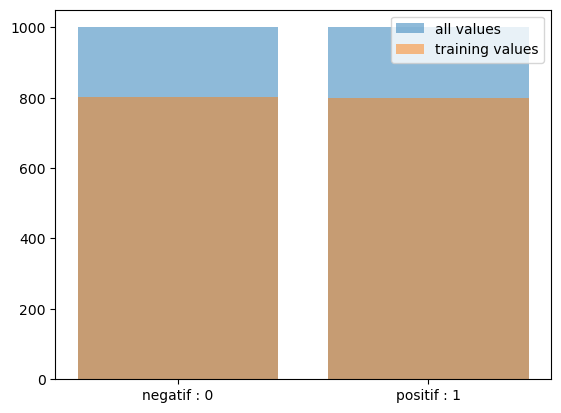

In [196]:
train_val = [sum([lab == 0 for lab in train_labs]), sum([lab == 1 for lab in train_labs])]
all_val = [sum([lab == 0 for lab in alllabs]), sum([lab == 1 for lab in alllabs])]

label = ['negatif : 0', 'positif : 1']

plt.bar(label, all_val, alpha=0.5, label='all values')
plt.bar(label, train_val, alpha=0.5, label='training values')
plt.legend(loc='upper right')
plt.show()

Dans ce cas ci, les données sont équilibrées entre les exemples d'avis positifs et négatifs sur les films. Il n'y aura donc pas besoin de réequilibrer les données.

### b) Preprocessing

> #### Transformation paramétrique du texte
Vous devez tester, par exemple, les cas suivants:
> - transformation en minuscule ou pas
> - suppression de la ponctuation
> - transformation des mots entièrement en majuscule en marqueurs spécifiques
> - suppression des chiffres ou pas
> - conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
> - stemming
> - ...

> Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [197]:
from sklearn.feature_extraction.text import CountVectorizer

Dans un premier temps, les documents sont utilisés **sans prétraitement**. Puis nous ajoutons **différents prétraitements** afin de les comparer. Enfin, nous essaierons, si cela semble pertinent, de **combiner les prétraitements** pour optimiser les performances.

In [198]:
#help(CountVectorizer)

#### i) Sans pretraitement

In [199]:
train_txts#Sans pré-traitement
vec_no_PP = CountVectorizer(lowercase=False)
X_no_PP = vec_no_PP.fit_transform(train_txts)
print('Vocabulaire Sans pré-traitement : \n', len(vec_no_PP.get_feature_names()), vec_no_PP.get_feature_names()[550:600]) # we only print a few

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple Sans pré-traitement :\n', exemple) 

Vocabulaire Sans pré-traitement : 
 36406 ['_should_', '_six_days', '_snl_', '_so', '_some_', '_star', '_still_', '_survives_', '_that_', '_the', '_the_', '_the_broadway_musical_', '_the_fugitive_', '_the_lion_king', '_the_quest_', '_their_', '_there_', '_they', '_this_', '_titanic_', '_titus_', '_titus_andronicus_', '_to', '_today_', '_too_', '_twice_', '_two_', '_urban', '_vampires_', '_very_', '_very_small_', '_wartime', '_wayyyyy_', '_what', '_whole_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhhs', 'aahs', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish']

Exemple Sans pré-traitement :
  i recall the trials and tribulations of my high school years . [...] 
So he pays someone $200 . 


C:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### ii) Sans ponctuation

In [200]:
def preprocess_ponct(text):
    """
    Transforms text to remove unwanted bits.
    """
    ponctuation = ["!", ":", ",", ".", "?", "+", "-", "&", "*", "%", "(",")", "_", '"', "'", "`", "[", "]", "*", "+", "-", "&", "%", "#"]
    for p in ponctuation:
        text = text.replace(p," ")
    return text # This function is only taking care of dots, what about !:,?+-&*%

In [201]:
#Clean text ponctuation
vec_Clean = CountVectorizer(preprocessor=preprocess_ponct)
X_Clean = vec_Clean.fit_transform(train_txts)
print('\n \nVocabulaire sans ponctuation: \n', len(vec_Clean.get_feature_names()), vec_Clean.get_feature_names()[550:600])

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple sans ponctuation :\n', preprocess_ponct(exemple))


 
Vocabulaire sans ponctuation: 
 36165 ['accentuate', 'accentuated', 'accentuates', 'accentuating', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'acception', 'accepts', 'access', 'accessibility', 'accessible', 'accessory', 'accident', 'accidental', 'accidentally', 'accidentlly', 'accidently', 'accidents', 'acclaim', 'acclaimed', 'acclimatize', 'accolade', 'accolades', 'accommodates', 'accommodating', 'accomodates', 'accompanied', 'accompanies', 'accompaniment', 'accompany', 'accompanying', 'accomplice', 'accomplices', 'accomplish', 'accomplished', 'accomplishes', 'accomplishment', 'accomplishments', 'accord', 'accordance', 'according', 'accordingly', 'accordion', 'accosted', 'accosts', 'account', 'accountability']

Exemple sans ponctuation :
  i recall the trials and tribulations of my high school years         
So he pays someone $200   


#### iii) Sans majuscules

In [202]:
def preprocess_maj(text):
    """
    Transforms text to change capital letters to lowercase letters.
    """
    return text.lower()

In [203]:
#Clean Text min/Maj
vec_mM = CountVectorizer(lowercase=True)
X_mM = vec_mM.fit_transform(train_txts)
print('\n \nTexte sans majuscules: \n', len(vec_mM.get_feature_names()), vec_mM.get_feature_names()[550:600])

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple sans majuscules :\n', preprocess_maj(exemple))


 
Texte sans majuscules: 
 36406 ['_should_', '_six_days', '_snl_', '_so', '_some_', '_star', '_still_', '_survives_', '_that_', '_the', '_the_', '_the_broadway_musical_', '_the_fugitive_', '_the_lion_king', '_the_quest_', '_their_', '_there_', '_they', '_this_', '_titanic_', '_titus_', '_titus_andronicus_', '_to', '_today_', '_too_', '_twice_', '_two_', '_urban', '_vampires_', '_very_', '_very_small_', '_wartime', '_wayyyyy_', '_what', '_whole_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhhs', 'aahs', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish']

Exemple sans majuscules :
  i recall the trials and tribulations of my high school years . [...] 
so he pays someone $200 . 


#### iv) Sans stop words

In [204]:
from collections import Counter

def most_common_words(texts, n):
    """
    """
    wc = Counter()
    for txt in texts:
        wc.update(txt.split(" "))
    
    freq = [f for w,f in wc.most_common(1000)]
    stop_words = [w for w,f in wc.most_common(n)]
    return stop_words

In [205]:
print(most_common_words(train_txts, 20))

[',', 'the', '.', 'a', 'of', 'and', 'to', 'is', 'in', '"', 'that', ')', '(', 'it', 'with', 'as', 'for', 'his', 'film', 'this']


In [206]:
from nltk.corpus import stopwords

def preprocess_sw(text):
    """
    Transforms text to remove unwanted bits.
    """
    stop_words = most_common_words(train_txts, 20)
    #stop_words = set(stopwords.words('english'))
    
    for sw in stop_words:
        text = text.replace(' '+sw+' '," ")
        text = text.replace('\n'+sw+' '," ")
        text = text.replace(' '+sw+'\n'," ")
    return text

In [207]:
#Remove stop words
stop_words = most_common_words(train_txts, 20)
vec_noSW_freq = CountVectorizer(stop_words=stop_words)
X_noSW_freq = vec_noSW_freq.fit_transform(train_txts)
print('\n \n Vocabulaire sans stop words (frequents) : \n', len(vec_noSW_freq.get_feature_names()), vec_noSW_freq.get_feature_names()[600:700]) # we only print a few

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple stop words (frequents) :\n', preprocess_sw(exemple))

vec_noSW = CountVectorizer(stop_words={'english'})
X_noSW = vec_noSW.fit_transform(train_txts)
print('\n \nVocabulaire sans stop words (par défaut) : \n', len(vec_noSW.get_feature_names()), vec_noSW.get_feature_names()[550:600]) # we only print a few


 
 Vocabulaire sans stop words (frequents) : 
 36392 ['ab', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abating', 'abbots', 'abbott', 'abbotts', 'abby', 'abc', 'abdomen', 'abducted', 'abductees', 'abduction', 'abductions', 'abdul', 'abe', 'abel', 'aberdeen', 'aberration', 'abeyance', 'abhorrence', 'abhorrent', 'abider', 'abides', 'abiding', 'abigail', 'abiility', 'abilities', 'ability', 'abject', 'ablaze', 'able', 'ably', 'abnormal', 'abnormally', 'abo', 'aboard', 'abode', 'abolish', 'abolitionist', 'abolitionists', 'abominable', 'abomination', 'aborginal', 'aboriginal', 'aboriginals', 'aborigine', 'abort', 'aborted', 'abortion', 'abortionist', 'abortions', 'abortive', 'aboslutely', 'abound', 'abounded', 'abounding', 'abounds', 'about', 'abouts', 'above', 'abraded', 'abraham', 'abrahams', 'abrams', 'abrasive', 'abreast', 'abril', 'abroad', 'abrupt', 'abruptly', 'abs', 'absconded', 'absence', 'absences', 'absense', 'absent', 'absentee', 'absinthe', 'absol

#### v) Sans chiffres

In [208]:
def preprocess_c(text):
    """
    Transforms text to remove unwanted bits.
    """
    chiffres = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    for c in chiffres:
        text = text.replace(c," ")
    return text

In [209]:
#suppression des chiffres
vec_noNb = CountVectorizer(preprocessor=preprocess_c)
X_noNb = vec_noNb.fit_transform(train_txts)
print('\n \nTexte sans chiffres: \n', len(vec_noNb.get_feature_names()), vec_noNb.get_feature_names()[550:600]) 

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple sans chiffres :\n', preprocess_c(exemple))


 
Texte sans chiffres: 
 35975 ['adjacent', 'adjective', 'adjectives', 'adjoining', 'adjuster', 'adjustments', 'adjusts', 'adlai', 'adlib', 'administered', 'administering', 'administration', 'administrative', 'admirable', 'admirably', 'admiral', 'admirals', 'admiration', 'admire', 'admired', 'admirer', 'admirers', 'admires', 'admiring', 'admission', 'admit', 'admiting', 'admits', 'admittance', 'admitted', 'admittedly', 'admitting', 'admittingly', 'admonition', 'ado', 'adolescence', 'adolescent', 'adolescents', 'adolf', 'adolph', 'adopt', 'adopted', 'adopter', 'adopting', 'adoption', 'adoptive', 'adopts', 'adorable', 'adorableness', 'adorably']

Exemple sans chiffres :
  i recall the trials and tribulations of my high school years . [...] 
So he pays someone $    . 


#### vi) Conservation d'une partie du texte seulement

In [210]:
#conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)

def preprocess_titre(text):
    """
    Transforms text to keep only the fisrt row.
    """
    ligne = text.split('\n')
    text = ligne[0]
    return text

def preprocess_resume(text):
    """
    Transforms text to keep only the last row.
    """
    ligne = text.split('\n')
    i = -1
    while ligne[i] == '':
        i-=1
    text = ligne[i]
    return text

In [211]:
#Part of the text
vec_title = CountVectorizer(preprocessor=preprocess_titre)
X_title = vec_title.fit_transform(train_txts)
print('\n \nTexte réduit à son titre : \n', len(vec_title.get_feature_names()), vec_title.get_feature_names()[550:600])

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple titre :\n', preprocess_titre(exemple))


vec_resume = CountVectorizer(preprocessor=preprocess_resume)
X_resume = vec_resume.fit_transform(train_txts)
print('\n \nTexte réduit à son résumé : \n', len(vec_resume.get_feature_names()), vec_resume.get_feature_names()[550:600]) 

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple résumé :\n', preprocess_resume(exemple))



 
Texte réduit à son titre : 
 6844 ['automatically', 'automobile', 'aux', 'available', 'avenging', 'average', 'avid', 'avoid', 'avoids', 'avowed', 'awaited', 'awaits', 'awaken', 'awakes', 'award', 'awarded', 'awards', 'aware', 'away', 'awe', 'awesome', 'awful', 'awhile', 'awkward', 'axe', 'ayla', 'az', 'ba', 'baadasssss', 'babe', 'babies', 'baby', 'babysitting', 'bachelor', 'back', 'backdrop', 'backers', 'background', 'bacon', 'bad', 'badly', 'baffles', 'baghdad', 'bahamas', 'bait', 'baldwin', 'ball', 'ballet', 'ballistic', 'ballyhoo']

Exemple titre :
  i recall the trials and tribulations of my high school years . [...] 

 
Texte réduit à son résumé : 
 5142 ['blown', 'bludgeons', 'blue', 'blueprint', 'blues', 'blurred', 'boast', 'bob', 'body', 'boldly', 'bolt', 'bond', 'bone', 'boneheaded', 'bont', 'boogie', 'boogieman', 'book', 'books', 'borderline', 'bore', 'bored', 'boring', 'born', 'borrowers', 'boss', 'boston', 'both', 'bother', 'bottle', 'bottom', 'bound', 'bow', 'bowed', 'b

#### vii) Vocabulaire réduit

In [212]:
#Variation de la taille du vocabulaire
vec_sizeVoc = CountVectorizer(max_df=100000,min_df=5,max_features=25000) #Changer params
X_sizeVoc = vec_sizeVoc.fit_transform(train_txts)
print('\n \nVocabulaire réduit : \n', len(vec_sizeVoc.get_feature_names()), vec_sizeVoc.get_feature_names()[550:600])


 
Vocabulaire réduit : 
 11704 ['ant', 'antagonists', 'anthony', 'anthropologist', 'anti', 'anticipated', 'anticipating', 'anticipation', 'anticlimactic', 'antics', 'antithesis', 'antonio', 'ants', 'antz', 'anxiety', 'anxious', 'any', 'anybody', 'anyhow', 'anymore', 'anyone', 'anything', 'anytime', 'anyway', 'anywhere', 'apart', 'apartment', 'ape', 'apes', 'aplomb', 'apocalypse', 'apocalyptic', 'apollo', 'apologize', 'appalling', 'apparent', 'apparently', 'appeal', 'appealing', 'appeals', 'appear', 'appearance', 'appearances', 'appeared', 'appearing', 'appears', 'applaud', 'applause', 'apple', 'applied']


#### viii) N-gram

In [213]:
#Unigram/bigram #####PARAMS A CHANGER
N_gram = (2,2)
vec_ngram22 = CountVectorizer(ngram_range=N_gram,analyzer='word') # Maybe 2-grams or 3-grams bring improvements ?
X_ngram22 = vec_ngram22.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram22.get_feature_names()), vec_ngram22.get_feature_names()[550:600])

N_gram = (3,3)
vec_ngram33 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram33 = vec_ngram33.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram33.get_feature_names()), vec_ngram33.get_feature_names()[550:600])

N_gram = (1,2)
vec_ngram12 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram12 = vec_ngram12.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram12.get_feature_names()), vec_ngram12.get_feature_names()[550:600])

N_gram = (1,3)
vec_ngram13 = CountVectorizer(ngram_range=N_gram,analyzer='word') 
X_ngram13 = vec_ngram13.fit_transform(train_txts)
print(f'\n \n N-gram {N_gram}: \n', len(vec_ngram13.get_feature_names()), vec_ngram13.get_feature_names()[550:600])



 
 N-gram (2, 2): 
 421966 ['1600s why', '161 an', '161 prison', '161 the', '165 mph', '167 minutes', '1692 at', '16mm 35mm', '16mm and', '16mm camera', '16mm was', '16th century', '16th floor', '16x9 televisions', '17 1997', '17 and', '17 but', '17 cannot', '17 day', '17 days', '17 due', '17 for', '17 hell', '17 in', '17 larger', '17 long', '17 mainly', '17 movie', '17 of', '17 people', '17 pg', '17 project', '17 rating', '17 territory', '17 the', '17 to', '17 whatever', '17 year', '17 years', '170 minutes', '1700s suddenly', '1709 is', '172 million', '175 million', '175 years', '1773 he', '1791 louisiana', '1792 she', '1793 but', '1794 bold']

 
 N-gram (3, 3): 
 811364 ['12 monkeys contaminated', '12 monkeys spacey', '12 monkeys was', '12 night celebration', '12 people when', '12 seconds of', '12 step programs', '12 tarzan features', '12 warriors and', '12 year old', '12 years his', '121 out of', '122 and braxton', '123 minutes at', '126 minute of', '126 minutes of', '127 minute ru

#### ix) Stemming

In [214]:
#Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize 

def preprocess_stemming(text):
    """
    Transforms text to keep only stemmed words.
    """
    ps = PorterStemmer()
    tokens = word_tokenize(text)
    stemmed = ''
    for token in tokens:
        stemmed_word = ps.stem(token)
        stemmed += (' ' + stemmed_word)
    return stemmed

In [215]:
#stemming
vec_stem = CountVectorizer(preprocessor=preprocess_stemming)
X_stem = vec_stem.fit_transform(train_txts)
print('\n \nTexte avec stemming : \n', len(vec_stem.get_feature_names()), vec_stem.get_feature_names()[550:600]) 

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple stemming :\n', preprocess_stemming(exemple))


 
Texte avec stemming : 
 25084 ['_this_', '_titanic_', '_titus_', '_titus_andronicus_', '_to', '_today_', '_too_', '_twice_', '_two_', '_urban', '_vampires_', '_very_', '_very_small_', '_wartim', '_wayyyyy_', '_what', '_whole_', '_william_shakespeare', '_would_', 'aa', 'aaa', 'aaaaaaaaah', 'aaaaaaaahhhh', 'aaaaaah', 'aaaahhh', 'aah', 'aaliyah', 'aalyah', 'aamir', 'aardman', 'aaron', 'aatish', 'ab', 'aback', 'abandon', 'abat', 'abbi', 'abbot', 'abbott', 'abc', 'abdomen', 'abduct', 'abducte', 'abdul', 'abe', 'abel', 'aberdeen', 'aberr', 'abey', 'abhorr']

Exemple stemming :
  i recal the trial and tribul of my high school year . [ ... ] so he pay someon $ 200 .


#### x) POS

In [216]:
#Part of speech tagging (POS)
from nltk.tag import pos_tag
import nltk
#nltk.download('averaged_perceptron_tagger')

def preprocess_pos(text):
    """
    Transforms text to keep only adjectives
    """
    tokens = word_tokenize(text)
    pt = pos_tag(tokens)
    pos = [word for word, tag in pt if tag =='JJ' or tag =='JJR' or tag =='JJS'] #adjectives
    tagged = ''
    for w in pos:
        tagged += (' ' + w)
    return tagged

In [217]:
#pos
vec_pos = CountVectorizer(preprocessor=preprocess_pos)
X_pos = vec_pos.fit_transform(train_txts)
print('\n \nTexte avec part of speech tagging : \n', len(vec_pos.get_feature_names()), vec_pos.get_feature_names()[550:600]) 

exemple = ' i recall the trials and tribulations of my high school years . [...] \nSo he pays someone $200 . '
print('\nExemple avec part of speech tagging (adjectifs) :\n', preprocess_pos(exemple))


 
Texte avec part of speech tagging : 
 11809 ['annual', 'anomaly', 'anonymous', 'answering', 'ant', 'antagonistic', 'antarctic', 'antennae', 'anthony', 'anthropological', 'anti', 'anticipated', 'anticlimactic', 'anticlimatic', 'anticlimaxic', 'antique', 'antiseptic', 'antisocial', 'antoine', 'antonio', 'antsy', 'antz', 'anxiety', 'anxious', 'anywhere', 'aol', 'apartheid', 'apathetic', 'apathy', 'ape', 'apes', 'aphrodiasiatic', 'apocalyptic', 'apollo', 'apologetic', 'apoplectic', 'apostle', 'appalachian', 'appalled', 'appalling', 'apparent', 'apparition', 'appeal', 'appealing', 'appealingly', 'appear', 'appearing', 'appeased', 'apple', 'applicable']

Exemple avec part of speech tagging (adjectifs) :
  high


Nous gardons alors les prétraitements qui nous intéressent pour la suite :

In [218]:
preprocessing = ['Sans pré-traitement', 
                 'Sans ponctuation', 
                 'Sans majuscules', 
                 'Sans stop words fréquents',
                 'Sans stop words par défaut',
                 'Sans chiffres',
                 'Conservation du titre',
                 'Conservation du résumé', 
                 'Vocabulaire réduit', 
                 'N-gram (2,2)',
                 'N-gram (3,3)',
                 'N-gram (1,2)',
                 'N-gram (1,3)',
                 'Stemming',
                 'Part of speech tagging']

prepross_X = [X_no_PP, X_Clean, X_mM, X_noSW_freq, X_noSW, X_noNb, X_title, 
              X_resume, X_sizeVoc, X_ngram22, X_ngram33, X_ngram12, X_ngram13,
              X_stem, X_pos]

pp_vectorizer = [vec_no_PP, vec_Clean, vec_mM, vec_noSW_freq, vec_noSW, vec_noNb, vec_title, 
                 vec_resume, vec_sizeVoc, vec_ngram22, vec_ngram33, vec_ngram12, vec_ngram13,
                 vec_stem, vec_pos]

### c) Extraction du vocabulaire

> #### Exploration préliminaire des jeux de données.
> - Quelle est la taille d'origine du vocabulaire?
> - Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]
> - Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]
> - Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]
> - Quelle est la distribution d'apparition des mots (Zipf)
> - Quels sont les 100 bigrammes/trigrammes les plus fréquents?

#### Quelle est la taille d'origine du vocabulaire ?

In [219]:
def get_size(vectorizer) :
    """
    Return the size of a vocabulary
    """
    return len(vectorizer.get_feature_names_out())

In [220]:
print("La taille d'origine du vocabulaire est de", get_size(vec_no_PP), 'mots.')

La taille d'origine du vocabulaire est de 36406 mots.


#### Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [221]:
from wordcloud import WordCloud

def word_cloud(corpus : list, stop_word : list = None):
    """
    Display word cloud
    """
    corpus = ' '.join(corpus)
    wordcloud = WordCloud(stopwords = stop_word).generate(corpus)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

In [222]:
def get_most_freq_word(X, vectorizer, n : int = 100):
    """
    Return the list of n words the most frequent
    """
    sum_words = X.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return [w for w,f in words_freq[:n]]

Si on ne garde que les 100 mots les plus fréquents :
 ['the', 'and', 'of', 'to', 'is', 'in', 'it', 'that', 'as', 'with', 'for', 'this', 'his', 'film', 'he', 'but', 'on', 'are', 'by', 'be', 'one', 'movie', 'an', 'who', 'not', 'you', 'from', 'was', 'at', 'have', 'they', 'has', 'her', 'all', 'there', 'out', 'like', 'so', 'about', 'up', 'more', 'what', 'when', 'which', 'their', 'or', 'she', 'some', 'just', 'can', 'if', 'we', 'him', 'into', 'even', 'no', 'than', 'only', 'good', 'time', 'most', 'its', 'will', 'story', 'would', 'been', 'character', 'much', 'also', 'well', 'get', 'other', 'them', 'two', 'very', 'do', 'first', 'characters', 'after', 'see', 'because', 'way', 'make', 'too', 'had', 'life', 'while', 'any', 'off', 'really', 'does', 'where', 'films', 'plot', 'little', 'how', 'people', 'could', 'then', 'over']


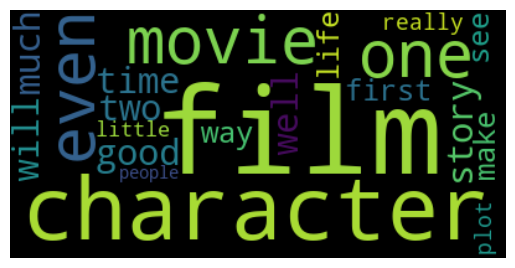

In [223]:
print("Si on ne garde que les 100 mots les plus fréquents :\n",get_most_freq_word(X_no_PP, vec_no_PP))
word_cloud(get_most_freq_word(X_no_PP, vec_no_PP))

#### Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

In [224]:
def get_doc_freq(X, vectorizer, n : int = 100):
        """
        Return the list of n words with the highest documentary frequency
        """
        words_freq = [(word, (np.transpose(X)[idx]!=0).sum(axis=1)[0,0]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        return [word for word, freq in words_freq[:n]]

Si on ne garde que 100 mots, les plus fréquents selon la fréquence documentaire :
 ['the', 'of', 'and', 'is', 'to', 'in', 'it', 'that', 'with', 'for', 'as', 'this', 'but', 'on', 'are', 'an', 'by', 'one', 'be', 'who', 'his', 'film', 'from', 'at', 'he', 'not', 'have', 'has', 'all', 'movie', 'out', 'was', 'there', 'they', 'like', 'so', 'you', 'more', 'about', 'up', 'when', 'what', 'or', 'some', 'can', 'just', 'if', 'into', 'which', 'even', 'only', 'their', 'than', 'time', 'no', 'good', 'most', 'would', 'him', 'much', 'her', 'we', 'other', 'well', 'get', 'been', 'will', 'two', 'story', 'do', 'after', 'also', 'its', 'character', 'first', 'them', 'way', 'make', 'see', 'very', 'while', 'does', 'any', 'she', 'off', 'too', 'characters', 'where', 'over', 'because', 'had', 'could', 'little', 'how', 'director', 'plot', 'best', 'people', 'then', 'really']


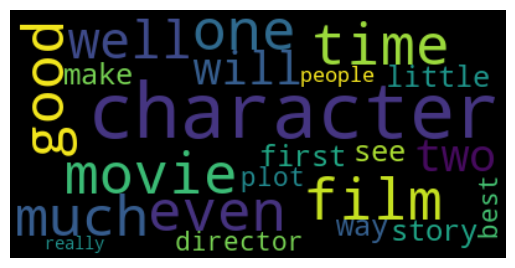

In [225]:
print("Si on ne garde que 100 mots, les plus fréquents selon la fréquence documentaire :\n",get_doc_freq(X_no_PP, vec_no_PP))
word_cloud(get_doc_freq(X_no_PP, vec_no_PP))

#### Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

In [226]:
def odd_ratio(p : float, q : float):
        """
        Calculate odd ratios from the frequencies p and q
        """
        if p not in [0,1] and q not in [0,1]:
            OR = (p*(1-q)) / (q*(1-p))
            return OR
        else:
            return 0

In [227]:
def get_oddratio(X, vectorizer, text, lab , n : int = 100):
        """
        Return  the list of n word the most frequent according to the odd ratio
        """
        #transform

        corpus1 = [text[i] for i in range(len(text)) if lab[i] == 1]
        corpus2 = [text[i] for i in range(len(text)) if lab[i] == 0]
        X_class1 = vectorizer.transform(corpus1)
        X_class2 = vectorizer.transform(corpus2)

        sum_words1 = X_class1.sum(axis=0)
        sum_words2 = X_class2.sum(axis=0)

        n_voc = len(vectorizer.vocabulary_)
        words_freq1 = [(word, sum_words1[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq2 = [(word, sum_words2[0, idx]) for word, idx in vectorizer.vocabulary_.items()]


        odd_ratios = [(word, odd_ratio(words_freq1[idx][1]/n_voc, words_freq2[idx][1]/n_voc)) for word, idx in vectorizer.vocabulary_.items()]
        odd_ratios = sorted(odd_ratios, key = lambda x: x[1], reverse=True)
        return [word for word,freq in odd_ratios[:n]]

Si on ne garde que les 100 mots les plus discriminants au sens du odd ratio :
 ['deceit', 'derived', 'elodie', 'fifteen', 'cardshark', 'francois', 'bro', 'labyrinthian', 'hors', 'immobilise', 'catharsis', 'crackin', 'efficiency', 'depressingly', 'pros', 'balk', 'bowie', 'dismembering', 'dianne', 'francoise', 'discover', 'finds', 'mega', 'dissapointing', 'assaulting', 'individuality', 'concussive', 'edvard', 'delivery', 'depicted', 'exclaims', 'ibn', 'astute', 'emerich', 'madmen', 'fortenberry', 'embeth', 'easygoing', 'mcdormand', 'montgomery', 'crowe', 'fires', 'basket', 'lengthens', 'delicacies', 'agreements', 'amalgamation', 'granted', 'gross', 'haviland', 'inputs', 'franz', 'aka', 'esterhas', 'blatancy', 'garr', 'incest', 'better', 'humankind', 'cherokee', 'assuredness', 'nutrition', 'saxophonist', 'divvy', 'eleventh', 'dreamer', 'collectors', 'conclusion', 'ark', 'coworker', 'expressions', 'dear', 'fireplace', 'clarence', 'arrietty', 'foundering', '1996', '1942', 'countless', 'coun

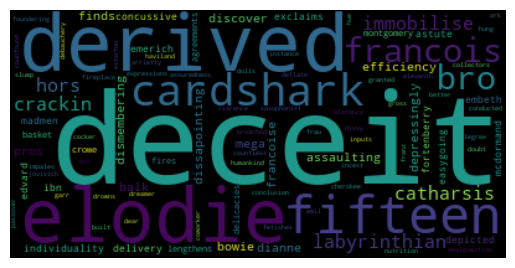

In [228]:
print("Si on ne garde que les 100 mots les plus discriminants au sens du odd ratio :\n",get_oddratio(X_no_PP, vec_no_PP, train_txts, train_labs))
word_cloud(get_oddratio(X_no_PP, vec_no_PP, train_txts, train_labs))

#### Quelle est la distribution d'apparition des mots (Zipf)

In [229]:
def plot_Zipf_distribution(X, vectorizer, n : int = 100) :
        """
        Plot the Zipf distribution of a text according to word frequency
        """
        sum_words = X.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
        words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
        freqs = [f for w,f in words_freq]

        # Plot
        rank = list(np.arange(1,len(freqs) +1))
        plt.figure(figsize=(10,10))
        plt.plot(np.log(rank), np.log(freqs))
        plt.xlabel('log(Rank)')
        plt.ylabel('log(Frequency)')
        plt.title('Zipf Distribution')
        #plt.savefig('./output/zipf_distribution.png', transparent = True)
        plt.show()

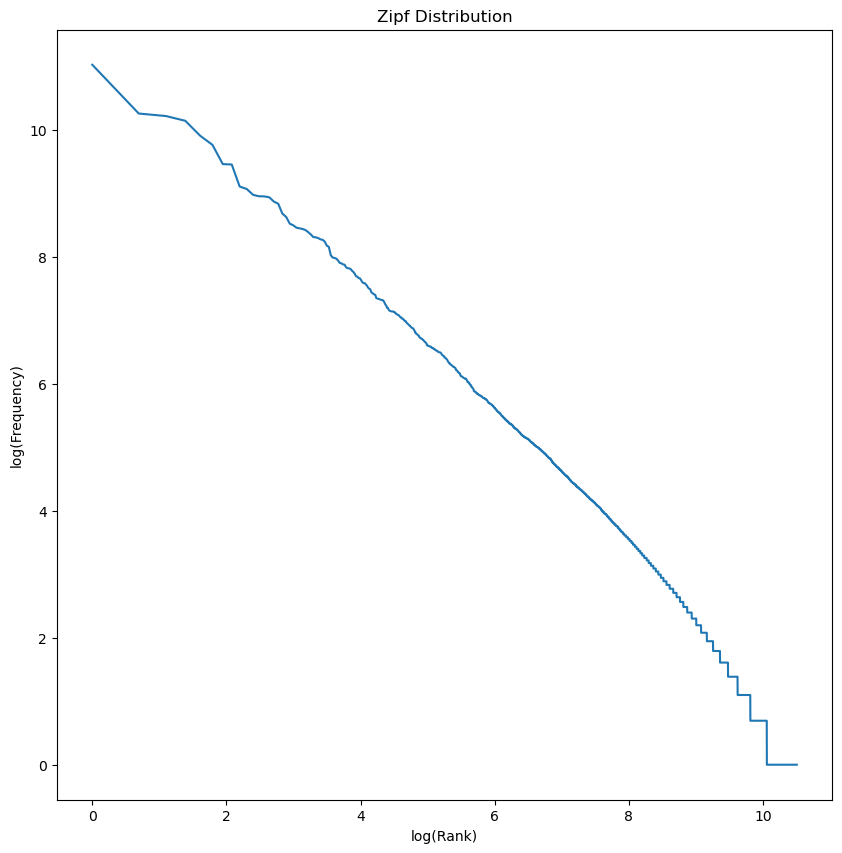

In [230]:
plot_Zipf_distribution(X_no_PP, vec_no_PP)

#### Quels sont les 100 bigrammes/trigrammes les plus fréquents?

In [231]:
def word_cloud_ngrams(corpus : list, stop_word : list = None):
    """
    Display word cloud
    """
    corpus = [w.replace(' ', '_') for w in corpus]
    corpus = ' '.join(corpus)
    wordcloud = WordCloud(stopwords = stop_word).generate(corpus)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")

Si on ne garde que les 100 bigrammes les plus fréquents :
 ['of the', 'in the', 'the film', 'to the', 'to be', 'and the', 'on the', 'the movie', 'with the', 'for the', 'it is', 'is the', 'one of', 'as the', 'this film', 'from the', 'at the', 'that the', 'this is', 'by the', 'this movie', 'out of', 'of his', 'the story', 'the most', 'he is', 'in this', 'the first', 'film is', 'there is', 'have been', 'that it', 'the same', 'is not', 'all the', 'to see', 'that he', 'into the', 'to make', 'there are', 'but it', 'but the', 'if you', 'of this', 'the end', 'and his', 'it was', 'that is', 'is that', 'the only', 'the best', 'about the', 'the audience', 'the plot', 'in his', 'to do', 'to get', 'they are', 'and it', 'of course', 'some of', 'more than', 'the way', 'would be', 'the characters', 'the other', 'at least', 'who is', 'has been', 'is an', 'trying to', 'with his', 'most of', 'movie is', 'he has', 'the world', 'when the', 'the two', 'which is', 'all of', 'to have', 'as well', 'played by',

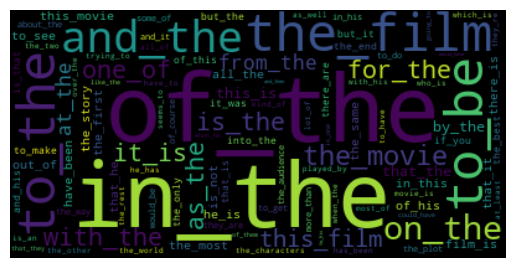

In [232]:
print("Si on ne garde que les 100 bigrammes les plus fréquents :\n",get_most_freq_word(X_ngram22, vec_ngram22))
word_cloud_ngrams(get_most_freq_word(X_ngram22, vec_ngram22))

Si on ne garde que les 100 trigrammes les plus fréquents :
 ['one of the', 'of the film', 'in the film', 'the film is', 'of the movie', 'some of the', 'the rest of', 'the fact that', 'in this film', 'rest of the', 'most of the', 'this film is', 'is one of', 'the movie is', 'of the most', 'in the movie', 'the end of', 'out of the', 'in order to', 'this is the', 'as well as', 'could have been', 'in this movie', 'seems to be', 'part of the', 'at the end', 'to be the', 'of the best', 'one of those', 'end of the', 'there is no', 'in the first', 'all of the', 'supposed to be', 'of this film', 'this movie is', 'in the end', 'would have been', 'the story is', 'the plot is', 'of the characters', 'of the story', 'the special effects', 'the film and', 'of the year', 'in love with', 'out to be', 'the story of', 'on the other', 'the kind of', 'if you re', 'in the middle', 'the film was', 'to do with', 'be able to', 'it is the', 'the middle of', 'that the film', 'that it is', 'based on the', 'the ot

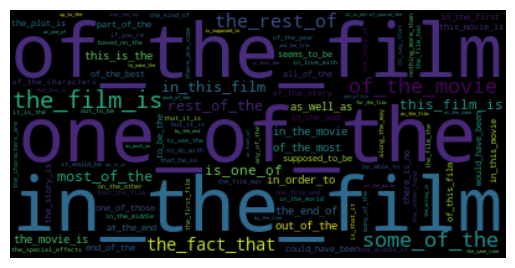

In [233]:
print("Si on ne garde que les 100 trigrammes les plus fréquents :\n",get_most_freq_word(X_ngram33, vec_ngram33))
word_cloud_ngrams(get_most_freq_word(X_ngram33, vec_ngram33))

### d) Training and Testing

> #### Modèles de Machine Learning
Avant de lancer de grandes expériences, il faut se construire une base de travail solide en étudiant les questions suivantes:
> - Combien de temps ça prend d'apprendre un classifieur NB/SVM/RegLog sur ces données en fonction de la taille du vocabulaire?
> - La validation croisée est-elle nécessaire? Est ce qu'on obtient les mêmes résultats avec un simple *split*?
> - La validation croisée est-elle stable? A partir de combien de fold (travailler avec différentes graines aléatoires et faire des statistiques basiques)?

> #### Première campagne d'expériences
Les techniques sur lesquelles nous travaillons étant sujettes au sur-apprentissage: trouver le paramètre de régularisation dans la documentation et optimiser ce paramètre au sens de la métrique qui vous semble la plus appropriée (cf question précédente).

In [234]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

NB_acc_score = []
LR_acc_score = []
SVM_acc_score = []

for index in range(len(prepross_X)):
    #TRAIN
    pp = preprocessing[index]
    X = prepross_X[index]
    vectorizer = pp_vectorizer[index]
    
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)

    #TEST
    true = test_labs
    X_test = vectorizer.transform(test_texts)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print('\n', pp)
    print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
    print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
    print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")
    
    NB_acc_score.append(accuracy_score(true, pred_nb))
    LR_acc_score.append(accuracy_score(true, pred_lr))
    SVM_acc_score.append(accuracy_score(true, pred_svm))


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Sans pré-traitement
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Sans ponctuation
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.865
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Sans majuscules
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87

 Sans stop words fréquents
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8725
SVM accuracy: 0.8625


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Sans stop words par défaut
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Sans chiffres
Naïve Bayes accuracy: 0.815
Logistic Regression accuracy: 0.8625
SVM accuracy: 0.87

 Conservation du titre
Naïve Bayes accuracy: 0.625
Logistic Regression accuracy: 0.5775
SVM accuracy: 0.57

 Conservation du résumé
Naïve Bayes accuracy: 0.6675
Logistic Regression accuracy: 0.6325
SVM accuracy: 0.6175


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Vocabulaire réduit
Naïve Bayes accuracy: 0.81
Logistic Regression accuracy: 0.88
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (2,2)
Naïve Bayes accuracy: 0.84
Logistic Regression accuracy: 0.8075
SVM accuracy: 0.8125


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (3,3)
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.725
SVM accuracy: 0.7425


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (1,2)
Naïve Bayes accuracy: 0.8325
Logistic Regression accuracy: 0.8625
SVM accuracy: 0.8775


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 N-gram (1,3)
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.8575
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 Stemming
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525

 Part of speech tagging
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8125


### e) Performances

#### i) Simple prétraitement

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

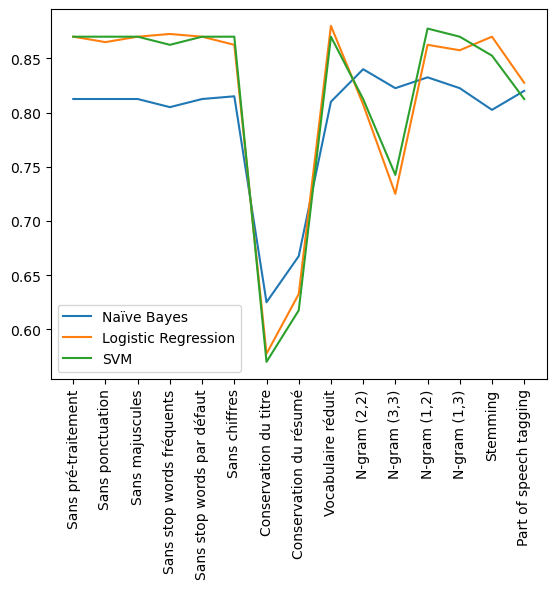

In [235]:
#Plots
plt.plot(preprocessing, NB_acc_score, label = 'Naïve Bayes')
plt.plot(preprocessing, LR_acc_score, label = 'Logistic Regression')
plt.plot(preprocessing, SVM_acc_score, label = 'SVM')
plt.legend(loc='lower left')
plt.xticks(rotation = 90)

In [236]:
#Selection des meilleurs pp et classifiers
index_NB = np.argmax(NB_acc_score)
index_LR = np.argmax(LR_acc_score)
index_SVM = np.argmax(SVM_acc_score)
print('Max NB : ', preprocessing[index_NB])
print('Max LR : ', preprocessing[index_LR])
print('Max SVM : ', preprocessing[index_SVM])

index_max = np.argmax([NB_acc_score[index_NB], LR_acc_score[index_LR], SVM_acc_score[index_SVM]])
print('Max preprocessing and classifier : ', ['NB', 'LR', 'SVM'][index_max], 
      'with', [preprocessing[index_NB], preprocessing[index_LR], preprocessing[index_SVM]][index_max])

Max NB :  N-gram (2,2)
Max LR :  Vocabulaire réduit
Max SVM :  N-gram (1,2)
Max preprocessing and classifier :  LR with Vocabulaire réduit


#### ii) Combinaison de prétraitements, Classifieurs et Performances

In [237]:
Preprocessings = [('Sans majuscules', preprocess_maj),
                 ('Sans ponctuation', preprocess_ponct),
                 ('Sans stop words', preprocess_sw),
                 ('Sans chiffres', preprocess_c),
                 ('Conservation du titre', preprocess_titre),
                 ('Conservation du résumé', preprocess_resume), 
                 ('Stemming', preprocess_stemming),
                 ('Part of speech tagging', preprocess_pos)]

ngrams = [('Unigram', (1,1)), ('(1,3)gram', (1,3))] #('Bigram', (2,2)), ('(1,2)gram', (1,2)), ('Trigram', (3,3))

In [238]:
def nuplets(l : list, k : int):
    """
    Create k-tuples from the elements of the list l
    """
    if k == 1:
        return [[x] for x in l]
    elif k== 2:
        return [[x, y] for x in l for y in l if x not in y and x > y]
    else :
        return [list([(x)]+ list(y)) for x in l for y in nuplets(l, k-1) if x not in y]

In [239]:
def combinaison_pp(preprocessing_functions : list):
    """
    Returns a preprocessing function which combines the preprocessings for a text
    Input : (preprocessing_functions) List of preprocessing functions
    Output : (inner) function
    """
    def inner(text):
        for function in preprocessing_functions:
            text = function(text)
        return text
    return inner

In [240]:
vec = CountVectorizer(lowercase=False, preprocessor=None)
X = vec.fit_transform(train_txts)
    
Names_tot = [['Sans Prétraitement']]
vec_tot = [vec]
ticks = ['Sans Prétraitement']
X_tot = [X]

for ngram in ngrams:
    
    for x in [1, 2]:

        ntuple = nuplets(Preprocessings, x)
        for studied in ntuple:

            preprocessing_functions = studied

            name_preprocessing = [name for name, function in preprocessing_functions] + [ngram[0]]
            function_preprocessing = [function for name, function in preprocessing_functions]

            preprocess = combinaison_pp(function_preprocessing)

            vec_combin = CountVectorizer(ngram_range = ngram[1], preprocessor=preprocess)
            X_combin = vec_combin.fit_transform(train_txts)

            X_tot.append(X_combin)
            Names_tot.append(name_preprocessing)
            vec_tot.append(vec_combin)
            ticks.append(' + '.join(name_preprocessing))



In [241]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

NB_acc_score = []
LR_acc_score = []
SVM_acc_score = []

for index in range(len(X_tot)):
    #TRAIN
    pp = Names_tot[index]
    X = X_tot[index]
    vectorizer = vec_tot[index]
    
    #Naïve Bayes
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)


    #Logistic Regression
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)

    #Linear SVM
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)

    #TEST
    true = test_labs
    X_test = vectorizer.transform(test_texts)

    pred_nb = nb_clf.predict(X_test)
    pred_lr = lr_clf.predict(X_test)
    pred_svm = svm_clf.predict(X_test)

    print('\n', pp)
    print(f"Naïve Bayes accuracy: {accuracy_score(true, pred_nb)}")
    print(f"Logistic Regression accuracy: {accuracy_score(true, pred_lr)}")
    print(f"SVM accuracy: {accuracy_score(true, pred_svm)}")
    
    NB_acc_score.append(accuracy_score(true, pred_nb))
    LR_acc_score.append(accuracy_score(true, pred_lr))
    SVM_acc_score.append(accuracy_score(true, pred_svm))

C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans Prétraitement']
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', 'Unigram']
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Unigram']
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.865
SVM accuracy: 0.87

 ['Sans stop words', 'Unigram']
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans chiffres', 'Unigram']
Naïve Bayes accuracy: 0.815
Logistic Regression accuracy: 0.8625
SVM accuracy: 0.87

 ['Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.625
Logistic Regression accuracy: 0.5775
SVM accuracy: 0.57

 ['Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.6675
Logistic Regression accuracy: 0.6325
SVM accuracy: 0.6175


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Unigram']
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525

 ['Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8125


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', 'Sans chiffres', 'Unigram']
Naïve Bayes accuracy: 0.815
Logistic Regression accuracy: 0.8625
SVM accuracy: 0.87

 ['Sans majuscules', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.625
Logistic Regression accuracy: 0.5775
SVM accuracy: 0.57

 ['Sans majuscules', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.6675
Logistic Regression accuracy: 0.6325
SVM accuracy: 0.6175

 ['Sans majuscules', 'Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8125


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Sans majuscules', 'Unigram']
Naïve Bayes accuracy: 0.8125
Logistic Regression accuracy: 0.865
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Sans chiffres', 'Unigram']
Naïve Bayes accuracy: 0.815
Logistic Regression accuracy: 0.8675
SVM accuracy: 0.87

 ['Sans ponctuation', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.625
Logistic Regression accuracy: 0.585
SVM accuracy: 0.575

 ['Sans ponctuation', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.6725
Logistic Regression accuracy: 0.6325
SVM accuracy: 0.6175


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.795
Logistic Regression accuracy: 0.8125
SVM accuracy: 0.7975

 ['Sans stop words', 'Sans majuscules', 'Unigram']
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.87
SVM accuracy: 0.87

 ['Sans stop words', 'Sans ponctuation', 'Unigram']
Naïve Bayes accuracy: 0.8075
Logistic Regression accuracy: 0.8725
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans stop words', 'Sans chiffres', 'Unigram']
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8725
SVM accuracy: 0.8625

 ['Sans stop words', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.61
Logistic Regression accuracy: 0.57
SVM accuracy: 0.5425

 ['Sans stop words', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.6775
Logistic Regression accuracy: 0.6575
SVM accuracy: 0.6225

 ['Sans stop words', 'Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.7875
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.7925

 ['Sans chiffres', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.6175
Logistic Regression accuracy: 0.5725
SVM accuracy: 0.5775

 ['Sans chiffres', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.665
Logistic Regression accuracy: 0.625
SVM accuracy: 0.6125

 ['Sans chiffres', 'Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.82
SVM accuracy: 0.805

 ['Con

C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans majuscules', 'Unigram']
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans ponctuation', 'Unigram']
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525

 ['Stemming', 'Sans stop words', 'Unigram']
Naïve Bayes accuracy: 0.805
Logistic Regression accuracy: 0.8675
SVM accuracy: 0.8525


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans chiffres', 'Unigram']
Naïve Bayes accuracy: 0.8
Logistic Regression accuracy: 0.865
SVM accuracy: 0.855


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.8025
Logistic Regression accuracy: 0.87
SVM accuracy: 0.8525

 ['Stemming', 'Part of speech tagging', 'Unigram']
Naïve Bayes accuracy: 0.7875
Logistic Regression accuracy: 0.8075
SVM accuracy: 0.8075

 ['Part of speech tagging', 'Conservation du titre', 'Unigram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8125

 ['Part of speech tagging', 'Conservation du résumé', 'Unigram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8125


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', '(1,3)gram']
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.8575
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', '(1,3)gram']
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.855
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans stop words', '(1,3)gram']
Naïve Bayes accuracy: 0.825
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.8675


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans chiffres', '(1,3)gram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.86
SVM accuracy: 0.875

 ['Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.6075
Logistic Regression accuracy: 0.5625
SVM accuracy: 0.54


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.68
Logistic Regression accuracy: 0.67
SVM accuracy: 0.66


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', '(1,3)gram']
Naïve Bayes accuracy: 0.8275
Logistic Regression accuracy: 0.865
SVM accuracy: 0.865


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.82
SVM accuracy: 0.83


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', 'Sans chiffres', '(1,3)gram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.86
SVM accuracy: 0.875

 ['Sans majuscules', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.6075
Logistic Regression accuracy: 0.5625
SVM accuracy: 0.54


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.68
Logistic Regression accuracy: 0.67
SVM accuracy: 0.66


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans majuscules', 'Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.82
SVM accuracy: 0.83


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Sans majuscules', '(1,3)gram']
Naïve Bayes accuracy: 0.8225
Logistic Regression accuracy: 0.855
SVM accuracy: 0.87


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Sans chiffres', '(1,3)gram']
Naïve Bayes accuracy: 0.82
Logistic Regression accuracy: 0.8575
SVM accuracy: 0.875

 ['Sans ponctuation', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.61
Logistic Regression accuracy: 0.57
SVM accuracy: 0.545


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.68
Logistic Regression accuracy: 0.6775
SVM accuracy: 0.6575


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans ponctuation', 'Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.79
Logistic Regression accuracy: 0.82
SVM accuracy: 0.82


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans stop words', 'Sans majuscules', '(1,3)gram']
Naïve Bayes accuracy: 0.825
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.8675


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans stop words', 'Sans ponctuation', '(1,3)gram']
Naïve Bayes accuracy: 0.83
Logistic Regression accuracy: 0.85
SVM accuracy: 0.8675


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans stop words', 'Sans chiffres', '(1,3)gram']
Naïve Bayes accuracy: 0.835
Logistic Regression accuracy: 0.8475
SVM accuracy: 0.8625

 ['Sans stop words', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.62
Logistic Regression accuracy: 0.56
SVM accuracy: 0.57

 ['Sans stop words', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.69
Logistic Regression accuracy: 0.67
SVM accuracy: 0.6075

 ['Sans stop words', 'Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.7825
Logistic Regression accuracy: 0.81
SVM accuracy: 0.82

 ['Sans chiffres', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.6
Logistic Regression accuracy: 0.545
SVM accuracy: 0.5425


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans chiffres', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.675
Logistic Regression accuracy: 0.6625
SVM accuracy: 0.65


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Sans chiffres', 'Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.8275
SVM accuracy: 0.8275

 ['Conservation du titre', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.6075
Logistic Regression accuracy: 0.5625
SVM accuracy: 0.54


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans majuscules', '(1,3)gram']
Naïve Bayes accuracy: 0.8275
Logistic Regression accuracy: 0.865
SVM accuracy: 0.865


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans ponctuation', '(1,3)gram']
Naïve Bayes accuracy: 0.8275
Logistic Regression accuracy: 0.865
SVM accuracy: 0.865


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans stop words', '(1,3)gram']
Naïve Bayes accuracy: 0.84
Logistic Regression accuracy: 0.85
SVM accuracy: 0.845


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Sans chiffres', '(1,3)gram']
Naïve Bayes accuracy: 0.825
Logistic Regression accuracy: 0.86
SVM accuracy: 0.8725


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.8275
Logistic Regression accuracy: 0.865
SVM accuracy: 0.865


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.8275
Logistic Regression accuracy: 0.865
SVM accuracy: 0.865


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Stemming', 'Part of speech tagging', '(1,3)gram']
Naïve Bayes accuracy: 0.7825
Logistic Regression accuracy: 0.805
SVM accuracy: 0.805


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Part of speech tagging', 'Conservation du titre', '(1,3)gram']
Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.82
SVM accuracy: 0.83


C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,



 ['Part of speech tagging', 'Conservation du résumé', '(1,3)gram']
Naïve Bayes accuracy: 0.7975
Logistic Regression accuracy: 0.82
SVM accuracy: 0.83


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, 

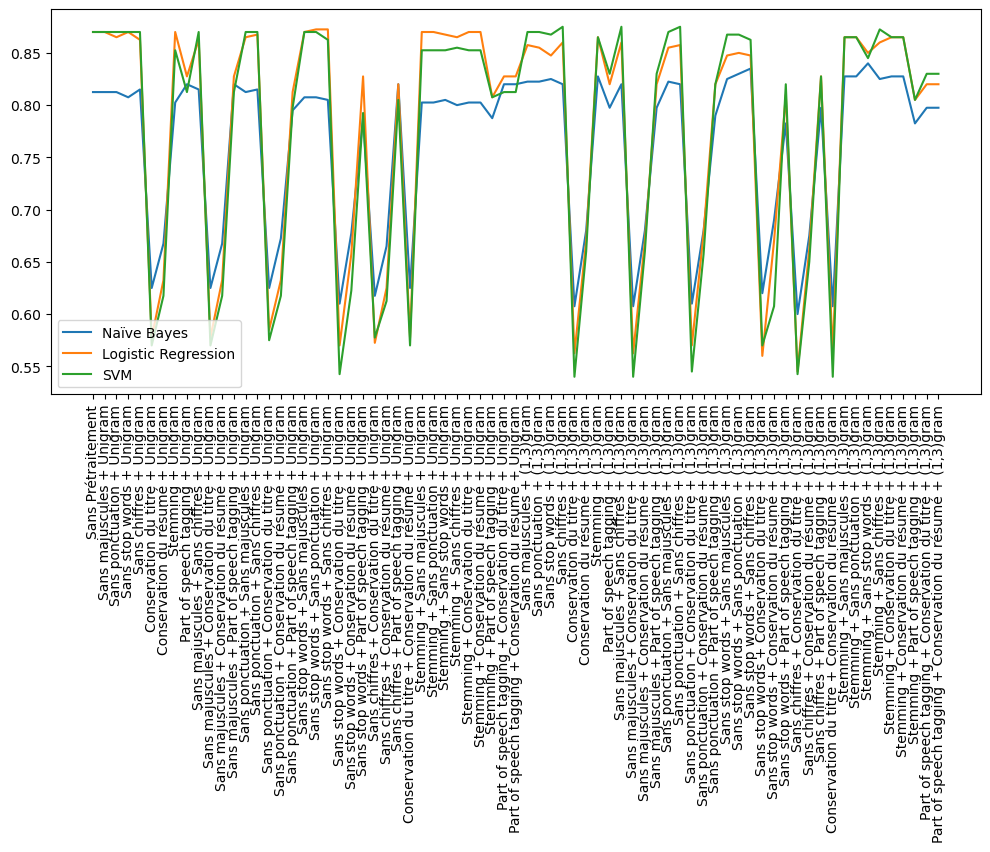

In [249]:
#Plots 

plt.figure(1, figsize=(12, 5))
plt.plot(ticks, NB_acc_score, label = 'Naïve Bayes')
plt.plot(ticks, LR_acc_score, label = 'Logistic Regression')
plt.plot(ticks, SVM_acc_score, label = 'SVM')
plt.legend(loc='lower left')
plt.xticks(rotation = 90)

In [251]:
#Selection des meilleurs pp et classifiers
index_NB = np.argmax(NB_acc_score) 
index_LR = np.argmax(LR_acc_score)
index_SVM = np.argmax(SVM_acc_score)
print('Max NB : ', ticks[index_NB])
print('Max LR : ', ticks[index_LR])
print('Max SVM : ', ticks[index_SVM])

index_max = np.argmax([NB_acc_score[index_NB], LR_acc_score[index_LR], SVM_acc_score[index_SVM]])
model = ['NB', 'LR', 'SVM'][index_max]
print('Max classifier : ', model, 
      'with preprocessing', [ticks[index_NB], ticks[index_LR], ticks[index_SVM]][index_max])

Max NB :  Stemming + Sans stop words + (1,3)gram
Max LR :  Sans stop words + Sans ponctuation + Unigram
Max SVM :  Sans chiffres + (1,3)gram
Max classifier :  SVM with preprocessing Sans chiffres + (1,3)gram


### f) Save results for optimal treatment

In [253]:
X_test = vectorizer.transform(test_texts)

#Naïve Bayes
if model == 'NB':
    
    pp = ticks[index_NB]
    X = X_tot[index_NB]
    vectorizer = vec_tot[index_NB]
    
    nb_clf = MultinomialNB()
    nb_clf.fit(X, train_labs)
    pred = nb_clf.predict(X_test)
    

elif model == 'LR':
    #Logistic Regression
    
    pp = ticks[index_LR]
    X = X_tot[index_LR]
    vectorizer = vec_tot[index_LR]
    
    lr_clf = LogisticRegression(random_state=0, solver='lbfgs',n_jobs=-1)
    lr_clf.fit(X, train_labs)
    pred = lr_clf.predict(X_test)
    

else:
    #Linear SVM
    
    pp = ticks[index_SVM]
    X = X_tot[index_SVM]
    vectorizer = vec_tot[index_SVM]
    
    svm_clf = LinearSVC(random_state=0, tol=1e-5)
    svm_clf.fit(X, train_labs)
    pred = svm_clf.predict(X_test)

C:\Anaconda\lib\site-packages\sklearn\svm\_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [257]:
file = open("output_movies/Results_opinion.txt", "a") 

file.write(f"Model : {model}, and Preprocessing : {pp}\n\n#A noter que les exemples de test sont ordonnés mais pas les exemples d'apprentissages choisis au hasard\n#L'ordre observé ici n'a donc pas influencé l'apprentissage\n\nEstimate    True Value    Text sample")

for movie in range(len(test_labs)):   
    
    first_line = test_texts[movie].split('\n')[0]
    file.write(f"\n{pred[movie]}    {test_labs[movie]}    {first_line}") 
    
file.close()